#TWI11 pytorch image binary classification model

First test of transfer learning on pytorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Importing library and data

In [52]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F   # activation functions
import torchvision
import torchvision.transforms as transforms   #image transformations

from torch.utils.data import Dataset, DataLoader  #image dataloading
from sklearn.model_selection import train_test_split

import tensorflow as tf

from __future__ import print_function 
from __future__ import division
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline

PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


foto's kopieren van / data naar train en test mappen om nog 2 foto's over te houden om mee te testen


In [3]:
#%cp -r "/content/drive/My Drive/Colab Notebooks/ToolWearInspection/data" "/content/drive/My Drive/Colab Notebooks/ToolWearInspection/data_train_test" 


In [6]:
import os
import glob
os.getcwd()
# place the files in your IDE working dicrectory .
#/content/drive/My Drive/Colab Notebooks/test/Image_binclassification_cactus_pytorch/data/

path = "/content/drive/My Drive/Colab Notebooks/ToolWearInspection/data_train_test/";
path11 = "/content/drive/My Drive/Colab Notebooks/ToolWearInspection/Test11/"

labels = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/ToolWearInspection/labels3.csv',delimiter=';')


test_labels = pd.DataFrame()

#test_labels maken om te kunnen verifieren
for filename in os.listdir(path+'test/'):
    if filename.endswith('.png'):
        cond = labels["img name"] == filename
        rows = labels.loc[cond, :]
        test_labels = test_labels.append(rows, ignore_index=True)
        labels = labels[labels['img name'] != filename]

#submission = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/test/Image_binclassification_cactus_pytorch/data/sample_submission.csv')

train_path = r'/content/drive/My Drive/Colab Notebooks/ToolWearInspection/data/'
test_path = r'/content/drive/My Drive/Colab Notebooks/ToolWearInspection/data_train_test/test'

##Label visualisation

In [7]:
labels.head()

,img name,value,Name,Name2,Category
0,t1-img.png,"50,73",LOW,LOW,0
1,t1b-img.png,"57,122",LOW,LOW,0
2,t2-img.png,"46,985",LOW,LOW,0
3,t2b-img.png,"68,904",LOW,LOW,0
5,t3b-img.png,"32,594",LOW,LOW,0


In [8]:
labels.tail()

,img name,value,Name,Name2,Category
94,t48-img.png,"466,956",HIGH,HIGH,1
95,t48b-img.png,"399,025",HIGH,HIGH,1
96,t49-img.png,"484,963",HIGH,HIGH,1
98,t50-img.png,"311,997",HIGH,HIGH,1
99,t50b-img.png,"451,317",HIGH,HIGH,1


In [9]:
labels['Category'].value_counts()

0    58
1    38
Name: Category, dtype: int64

In [10]:
test_labels.head()

,img name,value,Name,Name2,Category
0,t3-img.png,"35,349",LOW,LOW,0
1,t19-img.png,"108,938",LOW,LOW,0
2,t33b-img.png,"212,644",HIGH,MID,1
3,t49b-img.png,"536,966",HIGH,HIGH,1


In [11]:
test_labels['Category'].value_counts()

1    2
0    2
Name: Category, dtype: int64

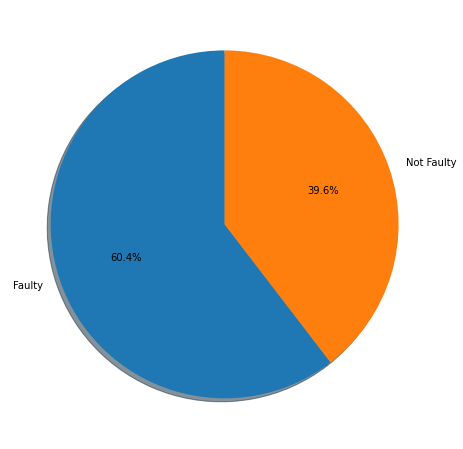

In [12]:
label = 'Faulty', 'Not Faulty'
plt.figure(figsize = (8,8))
plt.pie(labels.groupby('Category').size(), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

## Image Pre-processing

###Looking at pictures 

Bad pictures

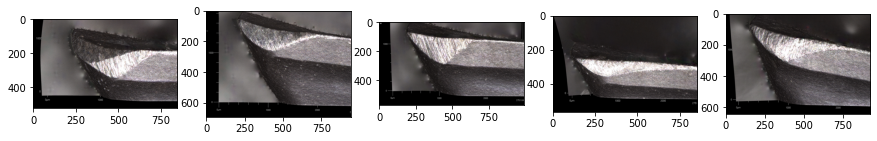

In [13]:

import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['Category'] == 1]['img name'][-5:]):
    path = os.path.join(train_path,idx)
    #print(img.imread(path).shape)
    ax[i].imshow(img.imread(path))

Good pictures

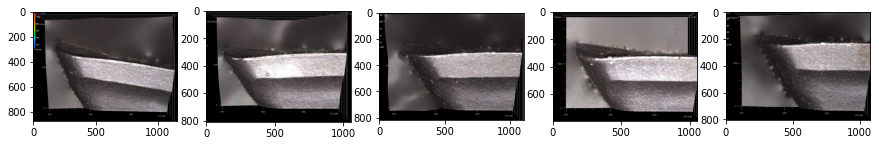

In [14]:
fig,ax = plt.subplots(1,5,figsize = (15,3))
for i,idx in enumerate(labels[labels['Category'] == 0]['img name'][:5]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

Test Set

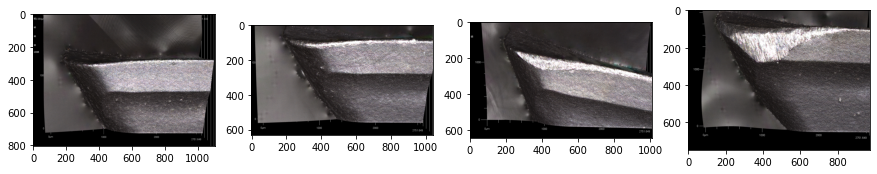

In [15]:
fig,ax = plt.subplots(1,4,figsize = (15,3))
for i,idx in enumerate(test_labels['img name'][:4]):
    path = os.path.join(test_path,idx)
    ax[i].imshow(img.imread(path))

###Dataset creation function

In [16]:
class TWIDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name = self.data[index][0]
        label = self.data[index][4]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)

        # deleting a dimension from image
        image = image[:,:,:3]
        
        #plt.imshow(image)    #show image for testing

        #print(image.shape)
        #imshow(image)
        #print(image.shape)
        if self.transform is not None:
            image = self.transform(image)
          
        #imshow(image)
        return image, label

Calculate mean and std for this dataset


In [17]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from tqdm.notebook import tqdm
from time import time

N_CHANNELS = 3

# transform to tensor
transform = transforms.Compose([transforms.ToPILImage(mode='RGB'),
                                transforms.Resize((224,224)),
                                transforms.ToTensor()])

# generate dataset
dataset = TWIDataset(labels, train_path, transform )
full_loader = DataLoader(dataset = dataset, shuffle=False, num_workers=os.cpu_count())

before = time()
mean = torch.zeros(N_CHANNELS)
std = torch.zeros(N_CHANNELS)
print('==> Computing mean and std..')
for inputs, _labels in tqdm(full_loader):
    #print(inputs.shape)
    for i in range(N_CHANNELS):
        mean[i] += inputs[:,i,:,:].mean()
        std[i] += inputs[:,i,:,:].std()
mean.div_(len(dataset))
std.div_(len(dataset))
print(mean, std)

print("time elapsed: ", time()-before)

==> Computing mean and std..



tensor([0.4859, 0.4861, 0.4819]) tensor([0.0859, 0.0860, 0.0853])
time elapsed:  22.067582845687866


Define imshow function to be able to see images

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.4859, 0.4861, 0.4819])   #waarden verkregen met bovenstaande cel om de mean en std te berekenen
        std = np.array([0.0859, 0.0860, 0.0853])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

## Normalization

defining the transforms
for this dataset no transformations will be executed since there is enough data available

In [27]:
print(mean, std)

tensor([0.4859, 0.4861, 0.4819]) tensor([0.0859, 0.0860, 0.0853])


transformations on: https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transforms



In [28]:
train_transform = transforms.Compose([transforms.ToPILImage(mode='RGB'),
                                      transforms.RandomAffine(degrees=5, translate=(0.1,0.1) , shear=(0.02,0.02)),
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std)])

test_transform = transforms.Compose([transforms.ToPILImage(mode='RGB'),
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean,std)])

valid_transform = transforms.Compose([transforms.ToPILImage(mode='RGB'),
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean,std)])

#transforms.CenterCrop(512),
#transforms.Resize((512,512)),

## Splitting the dataset

splitting

In [29]:
train, valid_data = train_test_split(labels, stratify=labels.Category, test_size=0.3)

applying the CactiDataset function to apply transforms and return a proper dataset

In [30]:
train_data = TWIDataset(train, train_path, train_transform )
valid_data = TWIDataset(valid_data, train_path, valid_transform )
test_data = TWIDataset(test_labels, test_path, test_transform)

In [31]:
# check dataset
train_data.__getitem__(0)

(tensor([[[-5.6542, -5.6542, -5.6542,  ..., -5.6542, -5.6542, -5.6542],
          [-5.6542, -5.6542, -5.6542,  ..., -5.6542, -5.6542, -5.6542],
          [-5.6542, -5.6542, -5.6542,  ..., -5.6542, -5.6542, -5.6542],
          ...,
          [-5.6542, -5.6542, -5.6542,  ..., -5.6542, -5.6542, -5.6542],
          [-5.6542, -5.6542, -5.6542,  ..., -5.6542, -5.6542, -5.6542],
          [-5.6542, -5.6542, -5.6542,  ..., -5.6542, -5.6542, -5.6542]],
 
         [[-5.6525, -5.6525, -5.6525,  ..., -5.6525, -5.6525, -5.6525],
          [-5.6525, -5.6525, -5.6525,  ..., -5.6525, -5.6525, -5.6525],
          [-5.6525, -5.6525, -5.6525,  ..., -5.6525, -5.6525, -5.6525],
          ...,
          [-5.6525, -5.6525, -5.6525,  ..., -5.6525, -5.6525, -5.6525],
          [-5.6525, -5.6525, -5.6525,  ..., -5.6525, -5.6525, -5.6525],
          [-5.6525, -5.6525, -5.6525,  ..., -5.6525, -5.6525, -5.6525]],
 
         [[-5.6483, -5.6483, -5.6483,  ..., -5.6483, -5.6483, -5.6483],
          [-5.6483, -5.6483,

## creating model

setting hyper parameters to affect the model running

In [32]:
# Hyper parameters

num_epochs = 35
num_classes = 2
batch_size = 16
learning_rate = 0.001

select GPU device

In [33]:
# CPU or GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

dataloader to create batches

In [34]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)

In [35]:


data, values = next(iter(train_loader))

print(data[0])
#imshow(data[0])
print(values)

tensor([[[-5.6542e+00, -5.6542e+00, -5.6542e+00,  ..., -5.6542e+00,
          -5.6542e+00, -5.6542e+00],
         [-5.6542e+00, -5.6542e+00, -5.6542e+00,  ..., -5.6542e+00,
          -5.6542e+00, -5.6542e+00],
         [-5.6542e+00, -5.6542e+00, -5.6542e+00,  ..., -5.6542e+00,
          -5.6542e+00, -5.6542e+00],
         ...,
         [-5.6542e+00, -5.6542e+00, -5.6542e+00,  ..., -8.6315e-01,
          -1.0913e+00, -1.2282e+00],
         [-5.6542e+00, -5.6542e+00, -5.6542e+00,  ...,  1.4069e-01,
           6.8824e-01,  6.4261e-01],
         [-5.6542e+00, -5.6542e+00, -5.6542e+00,  ..., -1.3651e+00,
          -1.3194e+00, -8.6315e-01]],

        [[-5.6525e+00, -5.6525e+00, -5.6525e+00,  ..., -5.6525e+00,
          -5.6525e+00, -5.6525e+00],
         [-5.6525e+00, -5.6525e+00, -5.6525e+00,  ..., -5.6525e+00,
          -5.6525e+00, -5.6525e+00],
         [-5.6525e+00, -5.6525e+00, -5.6525e+00,  ..., -5.6525e+00,
          -5.6525e+00, -5.6525e+00],
         ...,
         [-5.6525e+00, -5

The text creates a new imshow function, this is earlier declared so no need to do this

training images
torch.Size([3, 224, 224])


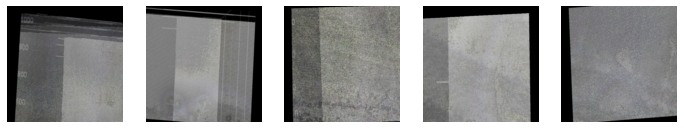

In [36]:
trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], ax=axe1, normalize=True)

print(trainimages[0].size())

Creating model

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_drop = nn.Dropout3d()
        self.fc1 = nn.Linear(32 * 54 * 54, 1024)
        #self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [38]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout3d(p=0.5, inplace=False)
  (fc1): Linear(in_features=93312, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


In [39]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [59]:
#%%time
# keeping-track-of-losses 

since = time.time()

val_acc_history = []
    
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()

        #print(data.shape)
        
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)

        _, preds = torch.max(outputs, 1)

        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    #statistics for epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    print('{} Loss: {:.4f} Acc: {:.4f}'.format("Train", epoch_loss, epoch_acc))

    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)

    #statistics for epoch
    epoch_loss = running_loss / len(valid_loader.dataset)
    epoch_acc = running_corrects.double() / len(valid_loader.dataset)
    print('{} Loss: {:.4f} Acc: {:.4f}'.format("Validation", epoch_loss, epoch_acc))
    
    # deep copy the model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    val_acc_history.append(epoch_acc)

    
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 1/34
----------
Train Loss: 0.0436 Acc: 0.6716
Validation Loss: 0.1008 Acc: 1.5517
Epoch: 1 	Training Loss: 0.589918 	Validation Loss: 0.575927
Epoch 2/34
----------
Train Loss: 0.0526 Acc: 0.6716
Validation Loss: 0.1216 Acc: 1.5517
Epoch: 2 	Training Loss: 0.645209 	Validation Loss: 0.625024
Epoch 3/34
----------
Train Loss: 0.0398 Acc: 0.6716
Validation Loss: 0.0920 Acc: 1.5517
Epoch: 3 	Training Loss: 0.571007 	Validation Loss: 0.654879
Epoch 4/34
----------
Train Loss: 0.0402 Acc: 0.6716
Validation Loss: 0.0928 Acc: 1.5517
Epoch: 4 	Training Loss: 0.544845 	Validation Loss: 0.644793
Epoch 5/34
----------
Train Loss: 0.0407 Acc: 0.6716
Validation Loss: 0.0941 Acc: 1.5517
Epoch: 5 	Training Loss: 0.560099 	Validation Loss: 0.649747
Epoch 6/34
----------
Train Loss: 0.0463 Acc: 0.6716
Validation Loss: 0.1070 Acc: 1.5517
Epoch: 6 	Training Loss: 0.562537 	Validation Loss: 0.666299
Epoch 7/34
----------
Train Loss: 0.0405 Acc: 0.6716
Validation Loss: 0.0936 Acc: 1.5517
Epoch: 7 	T

<All keys matched successfully>

In [50]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), path11+'Models/no_tl.ckpt')

Test Accuracy of the model: 55.172413793103445 %


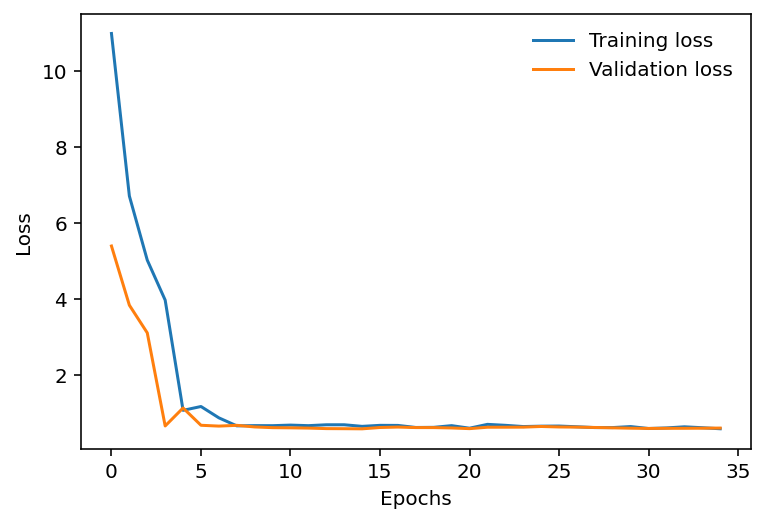

In [51]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)